In [1]:
import json
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

metrics_path = Path("../reports/metrics.json")
if not metrics_path.exists():
    raise FileNotFoundError("Run eval first: python -m src.cli.main eval --mode proxy")

with metrics_path.open("r", encoding="utf-8") as f:
    m = json.load(f)

m.keys()

dict_keys(['generated_at_utc', 'mode', 'inputs', 'detection', 'confidence', 'utility', 'mapping', 'artifacts'])

In [2]:
print("Mode:", m["mode"])
print("Detection macro_f1:", round(m["detection"]["macro_f1"], 4))
print("Detection weighted_f1:", round(m["detection"]["weighted_f1"], 4))
print("")
print("Confidence metrics")
print("  source:", m["confidence"]["similarity_source_column"])
print("  mean_cosine_similarity:", round(m["confidence"]["mean_cosine_similarity"], 4))
print(
    "  median_cosine_similarity:", round(m["confidence"]["median_cosine_similarity"], 4)
)
print("  std_cosine_similarity:", round(m["confidence"]["std_cosine_similarity"], 4))
print("")
print("Utility metrics")
print("  threshold:", m["utility"]["threshold"])
print(
    "  pct_mapped_sessions_above_threshold:",
    round(m["utility"]["pct_mapped_sessions_above_threshold"] * 100, 2),
    "%",
)
print(
    "  mapping_coverage_vs_scored_sessions:",
    round(m["utility"]["mapping_coverage_vs_scored_sessions"] * 100, 2),
    "%",
)

Mode: proxy
Detection macro_f1: 0.743
Detection weighted_f1: 0.9058

Confidence metrics
  source: confidence
  mean_cosine_similarity: 0.6482
  median_cosine_similarity: 0.6546
  std_cosine_similarity: 0.0283

Utility metrics
  threshold: 0.7
  pct_mapped_sessions_above_threshold: 0.35 %
  mapping_coverage_vs_scored_sessions: 61.76 %


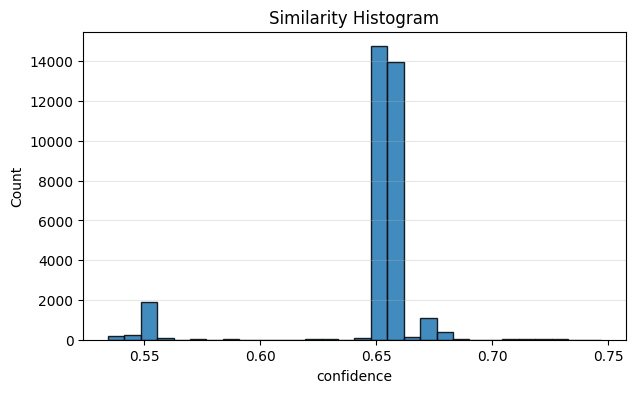

In [3]:
mapping = pd.read_parquet("../data/processed/session_attack_mapping.parquet")
sim_col = m["confidence"]["similarity_source_column"]
vals = pd.to_numeric(mapping[sim_col], errors="coerce").fillna(0)

plt.figure(figsize=(7, 4))
plt.hist(vals, bins=30, edgecolor="black", alpha=0.85)
plt.title("Similarity Histogram")
plt.xlabel(sim_col)
plt.ylabel("Count")
plt.grid(axis="y", alpha=0.3)
plt.show()

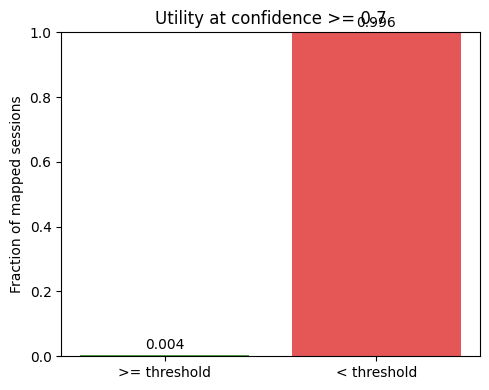

In [4]:
threshold = m["utility"]["threshold"]
conf = pd.to_numeric(mapping["confidence"], errors="coerce").fillna(0)
above = (conf >= threshold).mean()

plt.figure(figsize=(5, 4))
bars = plt.bar(
    [">= threshold", "< threshold"], [above, 1 - above], color=["#54a24b", "#e45756"]
)
plt.ylim(0, 1)
plt.ylabel("Fraction of mapped sessions")
plt.title(f"Utility at confidence >= {threshold}")
for b in bars:
    h = b.get_height()
    plt.text(b.get_x() + b.get_width() / 2, h + 0.02, f"{h:.3f}", ha="center")
plt.tight_layout()
plt.show()

In [5]:
import pandas as pd
import numpy as np

m = pd.read_parquet("../data/processed/session_attack_mapping.parquet").copy()


def first_item(x):
    if x is None:
        return None
    if hasattr(x, "tolist"):
        x = x.tolist()
    if isinstance(x, (list, tuple)) and len(x) > 0:
        return x[0]
    return None


m["top1_tid"] = m["mapped_techniques"].apply(first_item)
m["top1_name"] = m["mapped_names"].apply(first_item)
m["confidence"] = pd.to_numeric(m["confidence"], errors="coerce").fillna(0.0)
m["suspicious_score"] = pd.to_numeric(m["suspicious_score"], errors="coerce").fillna(
    0.0
)

# keep only sessions with mapped top1 technique
m = m.dropna(subset=["top1_tid"]).reset_index(drop=True)

# reduce clutter: keep top-N techniques by frequency
top_n = 25
top_tids = m["top1_tid"].value_counts().head(top_n).index
m_plot = m[m["top1_tid"].isin(top_tids)].copy()

# numeric indices for plotting
tid_order = m_plot["top1_tid"].value_counts().index.tolist()
tid_to_idx = {tid: i for i, tid in enumerate(tid_order)}
m_plot["tech_idx"] = m_plot["top1_tid"].map(tid_to_idx)
m_plot["session_idx"] = np.arange(len(m_plot))

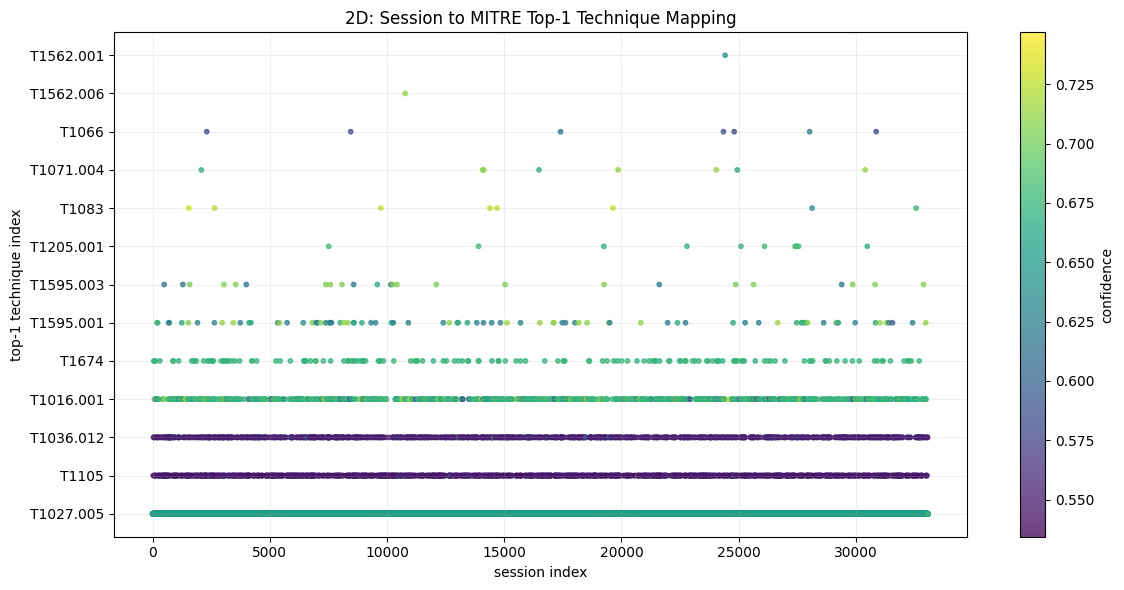

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sc = plt.scatter(
    m_plot["session_idx"],
    m_plot["tech_idx"],
    c=m_plot["confidence"],
    cmap="viridis",
    s=10,
    alpha=0.75,
)

plt.colorbar(sc, label="confidence")
plt.title("2D: Session to MITRE Top-1 Technique Mapping")
plt.xlabel("session index")
plt.ylabel("top-1 technique index")

# optional: show technique labels on y-axis
yticks = list(range(len(tid_order)))
ylabels = [f"{tid}" for tid in tid_order]
plt.yticks(yticks, ylabels)

plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()